In [ ]:
!pip install -q -U segmentation_models_pytorch
!pip install rasterio --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.1/549.1 kB 29.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 2.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.0/20.0 MB 46.1 MB/s eta 0:00:00


In [ ]:
import os
import pandas as pd
import numpy as np
import math

import torch
from torch import nn
import torch.nn.functional as F
from torchvision import transforms

from torch.utils.data import DataLoader, Dataset
from torch.utils.data.dataset import random_split

from osgeo import gdal, ogr, osr
import rasterio
from rasterio.plot import show

from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

import segmentation_models_pytorch as smp

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
class CFG:
    encoder = 'se_resnext50_32x4d'
    encoder_weights = 'imagenet'
    batch_size = 4
    num_epochs = 15
    lr = 1e-4
    seed = 0
    dataset_path = "/content/drive/MyDrive/Dataset3/sampling.csv"
    save_path = "/content/drive/MyDrive/Dataset3/model"

In [ ]:
def seed_everything(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available(): 
        torch.cuda.manual_seed(seed)
        torch.backends.cudnn.deterministic = True

seed_everything(CFG.seed)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
df = pd.read_csv(CFG.dataset_path, skiprows=[249], index_col=0)

In [ ]:
df.head()

TCWV  \
0  /content/drive/MyDrive/Dataset3/TCWV/2020/10/0...   
1  /content/drive/MyDrive/Dataset3/TCWV/2020/10/0...   
2  /content/drive/MyDrive/Dataset3/TCWV/2020/10/0...   
3  /content/drive/MyDrive/Dataset3/TCWV/2020/10/0...   
4  /content/drive/MyDrive/Dataset3/TCWV/2020/10/0...   

                                               radar  \
0  /content/drive/MyDrive/Dataset3/radar/2020/10/...   
1  /content/drive/MyDrive/Dataset3/radar/2020/10/...   
2  /content/drive/MyDrive/Dataset3/radar/2020/10/...   
3  /content/drive/MyDrive/Dataset3/radar/2020/10/...   
4  /content/drive/MyDrive/Dataset3/radar/2020/10/...   

                                                CAPE  \
0  /content/drive/MyDrive/Dataset3/CAPE/2020/10/0...   
1  /content/drive/MyDrive/Dataset3/CAPE/2020/10/0...   
2  /content/drive/MyDrive/Dataset3/CAPE/2020/10/0...   
3  /content/drive/MyDrive/Dataset3/CAPE/2020/10/0...   
4  /content/drive/MyDrive/Dataset3/CAPE/2020/10/0...   

                                                 TCC  \
0  /content/drive/MyDrive/Dataset3/TCC/2020/10/06...   
1  /content/drive/MyDrive/Dataset3/TCC/2020/10/06...   
2  /content/drive/MyDrive/Dataset3/TCC/2020/10/06...   
3  /content/drive/MyDrive/Dataset3/TCC/2020/10/06...   
4  /content/drive/MyDrive/Dataset3/TCC/2020/10/06...   

                                                 TCW  \
0  /content/drive/MyDrive/Dataset3/TCW/2020/10/06...   
1  /content/drive/MyDrive/Dataset3/TCW/2020/10/06...   
2  /content/drive/MyDrive/Dataset3/TCW/2020/10/06...   
3  /content/drive/MyDrive/Dataset3/TCW/2020/10/06...   
4  /content/drive/MyDrive/Dataset3/TCW/2020/10/06...   

                                                ISOR  \
0  /content/drive/MyDrive/Dataset3/ISOR/2020/10/0...   
1  /content/drive/MyDrive/Dataset3/ISOR/2020/10/0...   
2  /content/drive/MyDrive/Dataset3/ISOR/2020/10/0...   
3  /content/drive/MyDrive/Dataset3/ISOR/2020/10/0...   
4  /content/drive/MyDrive/Dataset3/ISOR/2020/10/0...   

                                                B09B  \
0  /content/drive/MyDrive/Dataset3/himawari/2020/...   
1  /content/drive/MyDrive/Dataset3/himawari/2020/...   
2  /content/drive/MyDrive/Dataset3/himawari/2020/...   
3  /content/drive/MyDrive/Dataset3/himawari/2020/...   
4  /content/drive/MyDrive/Dataset3/himawari/2020/...   

                                                B10B  \
0  /content/drive/MyDrive/Dataset3/himawari/2020/...   
1  /content/drive/MyDrive/Dataset3/himawari/2020/...   
2  /content/drive/MyDrive/Dataset3/himawari/2020/...   
3  /content/drive/MyDrive/Dataset3/himawari/2020/...   
4  /content/drive/MyDrive/Dataset3/himawari/2020/...   

                                                B16B  \
0  /content/drive/MyDrive/Dataset3/himawari/2020/...   
1  /content/drive/MyDrive/Dataset3/himawari/2020/...   
2  /content/drive/MyDrive/Dataset3/himawari/2020/...   
3  /content/drive/MyDrive/Dataset3/himawari/2020/...   
4  /content/drive/MyDrive/Dataset3/himawari/2020/...   

                                                B11B  \
0  /content/drive/MyDrive/Dataset3/himawari/2020/...   
1  /content/drive/MyDrive/Dataset3/himawari/2020/...   
2  /content/drive/MyDrive/Dataset3/himawari/2020/...   
3  /content/drive/MyDrive/Dataset3/himawari/2020/...   
4  /content/drive/MyDrive/Dataset3/himawari/2020/...   

                                                B12B  \
0  /content/drive/MyDrive/Dataset3/himawari/2020/...   
1  /content/drive/MyDrive/Dataset3/himawari/2020/...   
2  /content/drive/MyDrive/Dataset3/himawari/2020/...   
3  /content/drive/MyDrive/Dataset3/himawari/2020/...   
4  /content/drive/MyDrive/Dataset3/himawari/2020/...   

                                                B14B  \
0  /content/drive/MyDrive/Dataset3/himawari/2020/...   
1  /content/drive/MyDrive/Dataset3/himawari/2020/...   
2  /content/drive/MyDrive/Dataset3/himawari/2020/...   
3  /content/drive/MyDrive/Dataset3/himawari/2020/...   
4  /content/drive/MyDrive/Dataset3/himawari/2020/...   

    

In [ ]:
class RainDataset(Dataset):
    def __init__(self, df):
        self.df = df
        self.train_col = ["ISOR", "CAPE", "TCWV", "TCC", "TCW", "IRB",
                            "B10B", "B16B", "B11B", "I2B", "WVB", "B09B"]

        self.img = self.df[self.train_col]

        self.gt = self.df["radar"]

    def __len__(self):
        return len(self.df)

    def __getitem__(self, i):
        raw_input = []
        input = []

        for j in range(len(self.img.iloc[i])):
            raw_input.append(self.read_image(self.img.iloc[i][j]))
        
        for j in range(5):
          input.append(raw_input[j])

        input.append(raw_input[self.train_col.index("IRB")])
        input.append(np.subtract(raw_input[self.train_col.index("B10B")], raw_input[self.train_col.index("B16B")]))
        input.append(np.subtract(raw_input[self.train_col.index("B11B")], raw_input[self.train_col.index("IRB")]))
        input.append(np.subtract(raw_input[self.train_col.index("IRB")], raw_input[self.train_col.index("I2B")]))
        input.append(np.subtract(raw_input[self.train_col.index("WVB")], raw_input[self.train_col.index("B09B")]))
        input.append(np.subtract(raw_input[self.train_col.index("B09B")], raw_input[self.train_col.index("B10B")]))
        
        input = torch.from_numpy(np.concatenate(input, axis=0))
        gt = torch.from_numpy(self.read_image(self.gt.iloc[i]))
        
        return input, gt
    
    def read_image(self, path):
        img = gdal.Open(path)
        img_arr = img.GetRasterBand(1).ReadAsArray()
        return img_arr.reshape(-1, 512, 512)

In [ ]:
dataset = RainDataset(df)

In [ ]:
def split_train_val_test(dataset, val_ratio=0.1, test_ratio=0.2):
    test_length = int(len(dataset) * test_ratio)
    val_length = int(len(dataset) * val_ratio)
    train_length = len(dataset) - val_length - test_length
    return random_split(
        dataset, lengths=[train_length, val_length, test_length]
    )


train_ds, val_ds, test_ds = split_train_val_test(dataset)

In [ ]:
train_loader = DataLoader(train_ds, batch_size=CFG.batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_ds, batch_size=CFG.batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_ds, batch_size=CFG.batch_size, shuffle=False, num_workers=2)

In [ ]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [ ]:
model = smp.Unet(encoder_name=CFG.encoder,
                 encoder_weights=CFG.encoder_weights,
                 in_channels=11,
                 encoder_depth=5,
                 classes=1)

Downloading: "http://data.lip6.fr/cadene/pretrainedmodels/se_resnext50_32x4d-a260b3a4.pth" to /root/.cache/torch/hub/checkpoints/se_resnext50_32x4d-a260b3a4.pth
100%|██████████| 105M/105M [05:10<00:00, 356kB/s]


In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

count_parameters(model)

34549057

In [ ]:
def train(model, optimizer, criterion, train_loader):
    train_loss = 0

    model.train()
    for image, gt in tqdm(train_loader, leave=False):
        image = image.to(device)
        gt = gt.to(device)

        optimizer.zero_grad()
        predict = model(image)

        mask = gt >= 0
        gt = gt[mask]
        predict = predict[mask]
        
        loss = criterion(predict, gt)
        
        loss.backward()

        optimizer.step()

        train_loss += loss.item()
    
    return train_loss / len(train_loader)

def val(model, criterion, val_loader):
    val_loss = 0

    model.eval()
    for image, gt in tqdm(val_loader, leave=False):
        image, gt = image.to(device), gt.to(device)

        with torch.no_grad():
            predict = model(image)
            mask = gt >= 0
            predict = predict[mask]
            gt = gt[mask]
            loss = criterion(predict, gt)
            val_loss += loss.item()

    return val_loss / len(val_loader)

def test(model, criterion, test_loader):
    test_loss = 0
    gts, preds = [], []
    
    model.eval()
    for image, gt in tqdm(test_loader, leave=False):
        image, gt = image.to(device), gt.to(device)

        with torch.no_grad():
            predict = model(image)
            mask = gt >= 0
            gts.append(gt)
            preds.append(predict)
            predict = predict[mask]
            gt = gt[mask]
            loss = criterion(predict, gt)
            test_loss += loss.item()

    return test_loss / len(test_loader), preds, gts

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=CFG.lr, weight_decay=1e-05)
criterion = nn.MSELoss()

In [ ]:
model.to(device)

Unet(
  (encoder): SENetEncoder(
    (layer0): Sequential(
      (conv1): Conv2d(11, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu1): ReLU(inplace=True)
      (pool): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    )
    (layer1): Sequential(
      (0): SEResNeXtBottleneck(
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

In [ ]:
train_losses = []
val_losses = []
test_losses = []

best_loss = 100

for epoch in range(CFG.num_epochs):
    train_loss = train(model, optimizer, criterion, train_loader)
    val_loss = val(model, criterion, val_loader)
    test_loss, _, _ = test(model, criterion, test_loader)

    
    train_losses.append(math.sqrt(train_loss))
    val_losses.append(math.sqrt(val_loss))
    test_losses.append(math.sqrt(test_loss))

    print('Epoch {:d} || train loss = {:.4f} || val loss = {:.4f} || test loss = {:.4f}'.format(
            epoch + 1, math.sqrt(train_loss), math.sqrt(val_loss), math.sqrt(test_loss)))
    
    if test_loss < best_loss:
        best_loss = test_loss
        torch.save(model.state_dict(), f'{CFG.save_path}/{CFG.encoder}-{CFG.seed}.pth')

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 1 || train loss = 3.7482 || val loss = 3.3586 || test loss = 3.8596


  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 2 || train loss = 3.3668 || val loss = 3.2482 || test loss = 3.6298


  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 3 || train loss = 3.2114 || val loss = 3.2519 || test loss = 3.7313


  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 4 || train loss = 3.0500 || val loss = 3.0796 || test loss = 3.5714


  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 5 || train loss = 2.9276 || val loss = 2.9937 || test loss = 3.5109


  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 6 || train loss = 2.7873 || val loss = 2.9676 || test loss = 3.4048


  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 7 || train loss = 2.6615 || val loss = 2.9547 || test loss = 3.4107


  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 8 || train loss = 2.5637 || val loss = 2.9538 || test loss = 3.3846


  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 9 || train loss = 2.5020 || val loss = 3.0046 || test loss = 3.3360


  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 10 || train loss = 2.4056 || val loss = 2.8684 || test loss = 3.3506


  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 11 || train loss = 2.2949 || val loss = 2.8916 || test loss = 3.3083


  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 12 || train loss = 2.2150 || val loss = 2.8752 || test loss = 3.3532


  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 13 || train loss = 2.1108 || val loss = 2.8736 || test loss = 3.3368


  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 14 || train loss = 2.0460 || val loss = 2.9499 || test loss = 3.4043


  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 15 || train loss = 2.0106 || val loss = 2.8619 || test loss = 3.3412


In [ ]:
state_dict = torch.load(f'{CFG.save_path}/{CFG.encoder}-{CFG.seed}.pth')
model.load_state_dict(state_dict)

test_loss, pred, target = test(model, criterion, test_loader)
print(f"Test MSE: {format(test_loss, '.4f')}")
print(f"Test RMSE: {format(math.sqrt(test_loss), '.4f')}")

  0%|          | 0/13 [00:00<?, ?it/s]

Test MSE: 10.9445
Test RMSE: 3.3083


In [ ]:
def array2raster(newRasterfn, rasterOrigin, pixelWidth, pixelHeight, array):

    cols = array.shape[1]
    rows = array.shape[0]
    originX = rasterOrigin[0]
    originY = rasterOrigin[1]

    driver = gdal.GetDriverByName('GTiff')
    outRaster = driver.Create(newRasterfn, cols, rows, 1, gdal.GDT_Byte)
    outRaster.SetGeoTransform((originX, pixelWidth, 0, originY, 0, pixelHeight))
    outband = outRaster.GetRasterBand(1)
    outband.WriteArray(array)
    outRasterSRS = osr.SpatialReference()
    outRasterSRS.ImportFromEPSG(4326)
    outRaster.SetProjection(outRasterSRS.ExportToWkt())
    outband.FlushCache()

In [ ]:
def plot(target_path, pred_path):
  target = rasterio.open(target_path)
  pred = rasterio.open(pred_path)

  fig, (axt, axp) = plt.subplots(1,2, figsize=(10,10))
  show(target, ax=axt, title='target')
  show(pred, ax=axp, title='predict')
  plt.show()

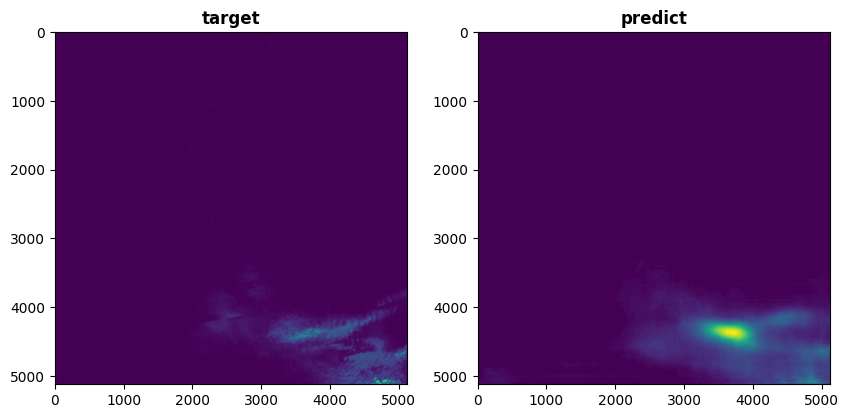

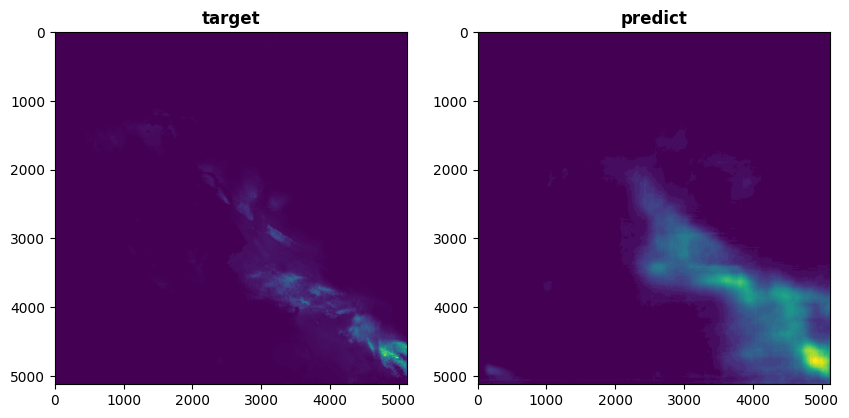

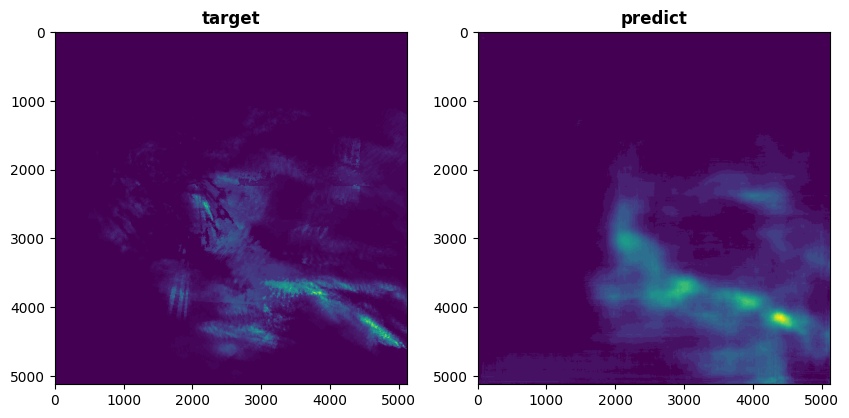

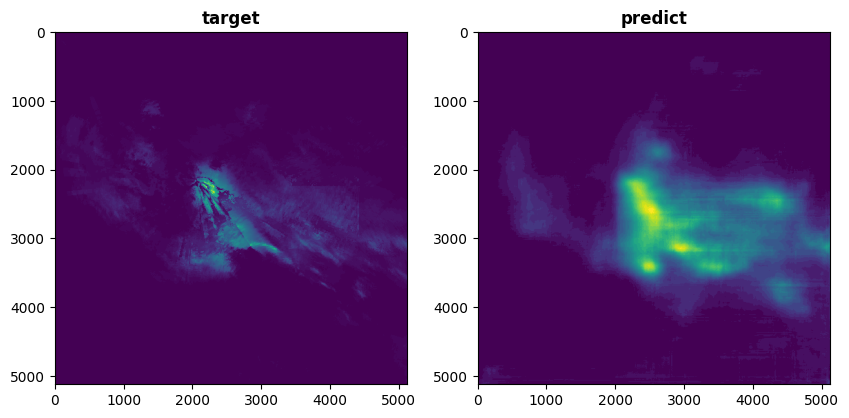

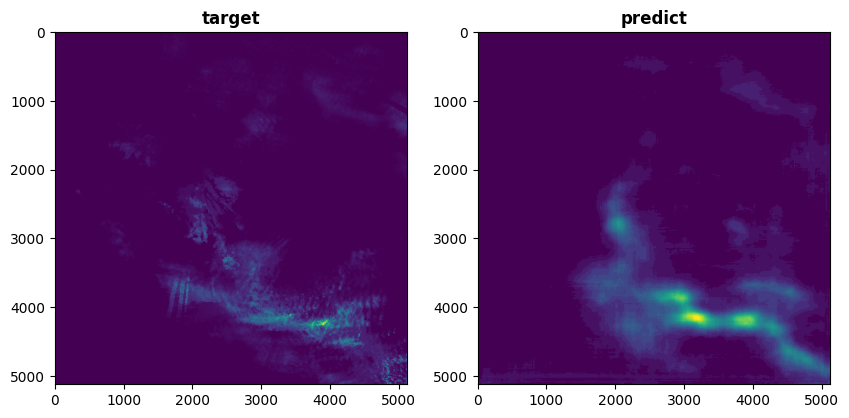

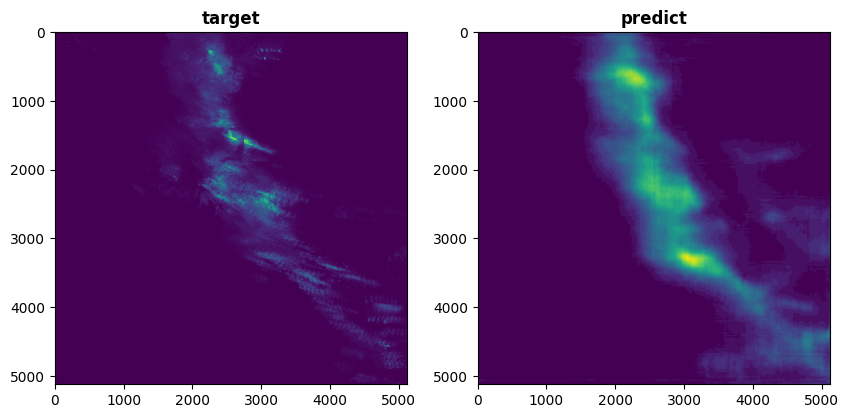

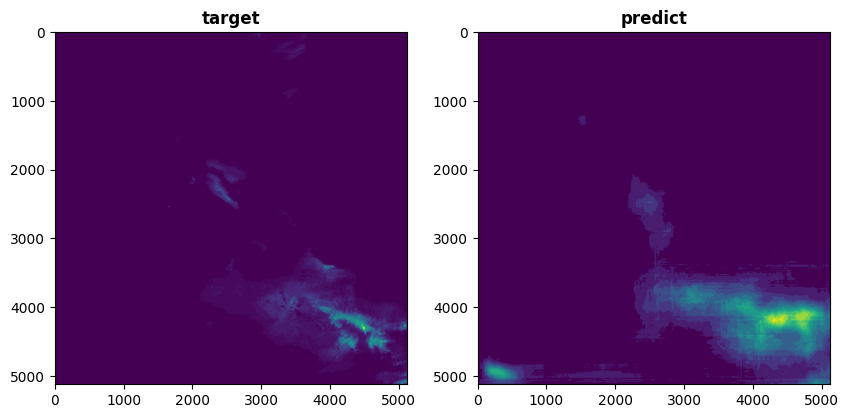

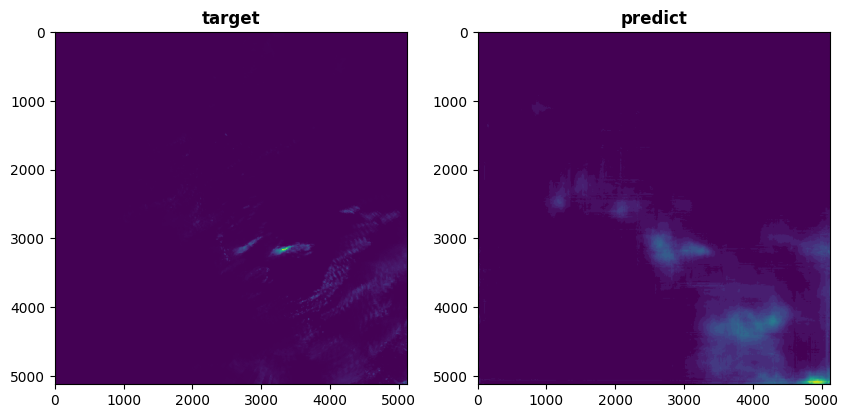

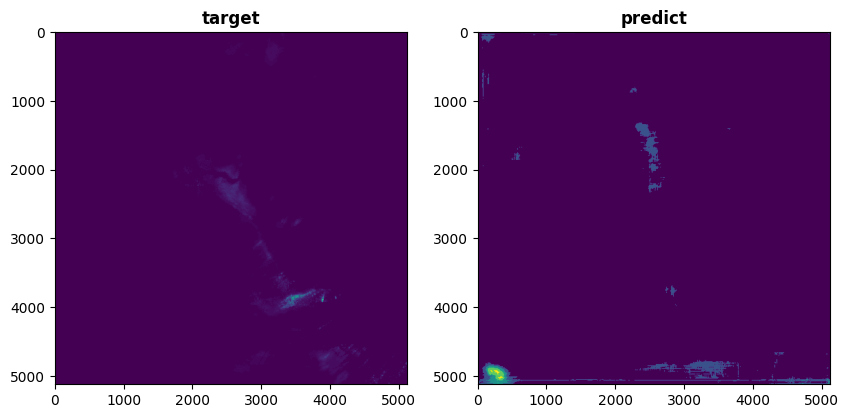

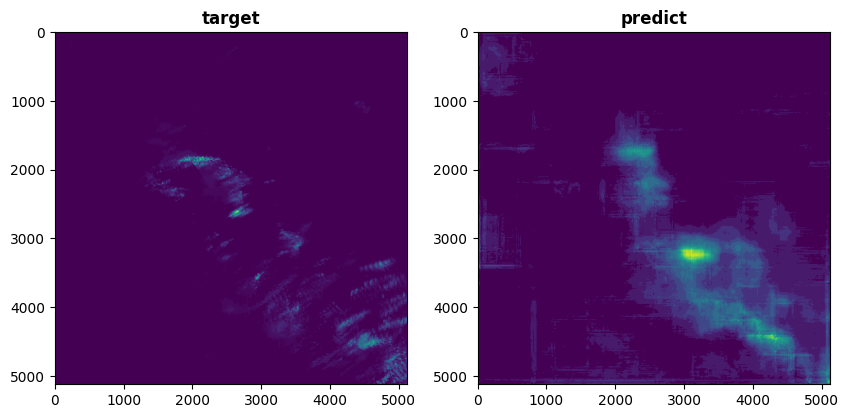

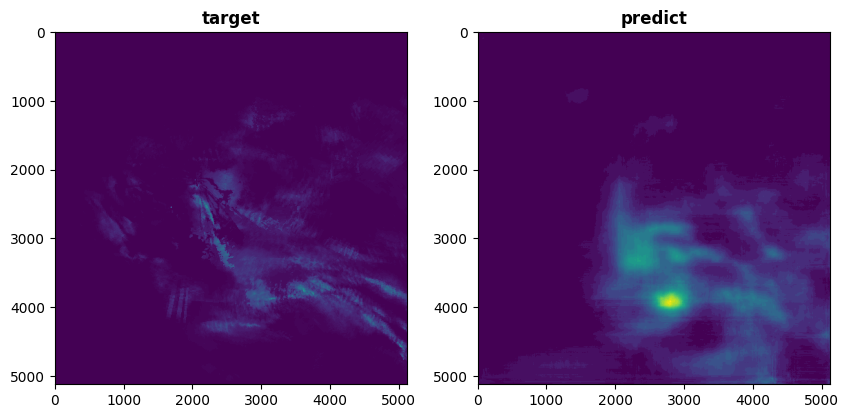

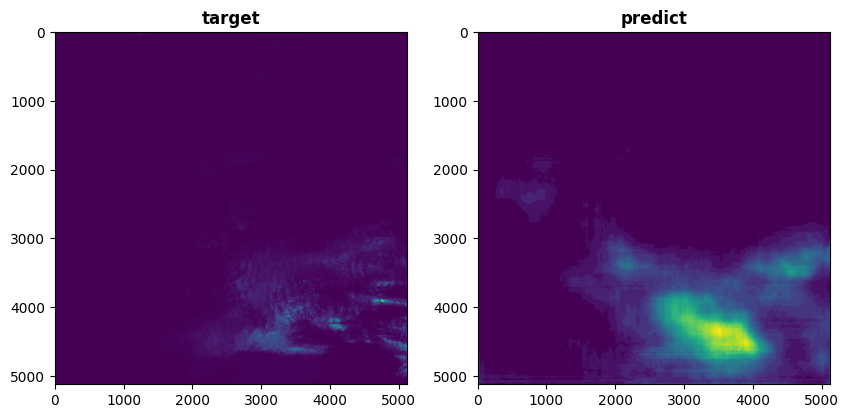

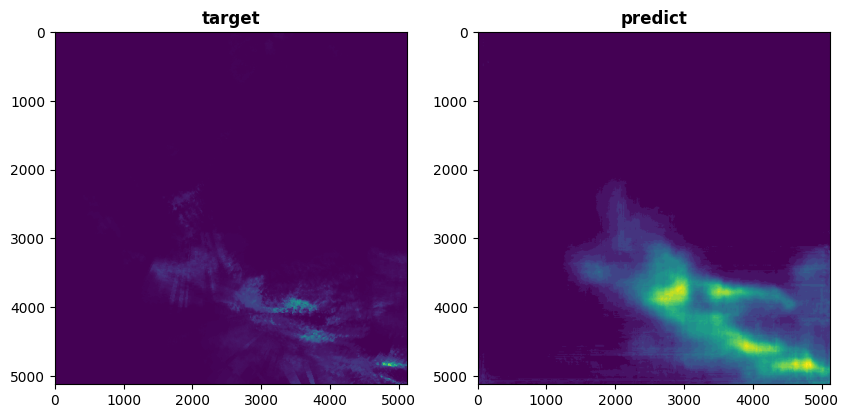

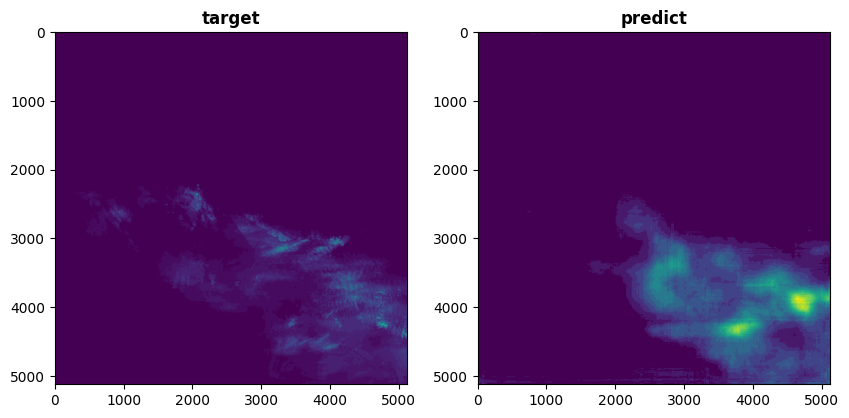

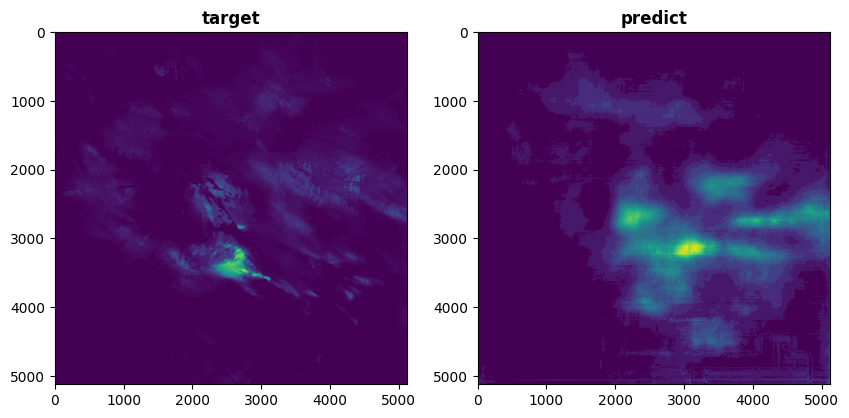

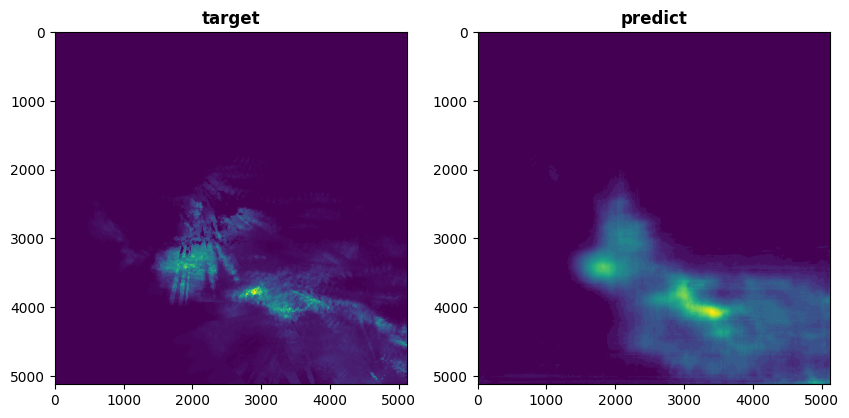

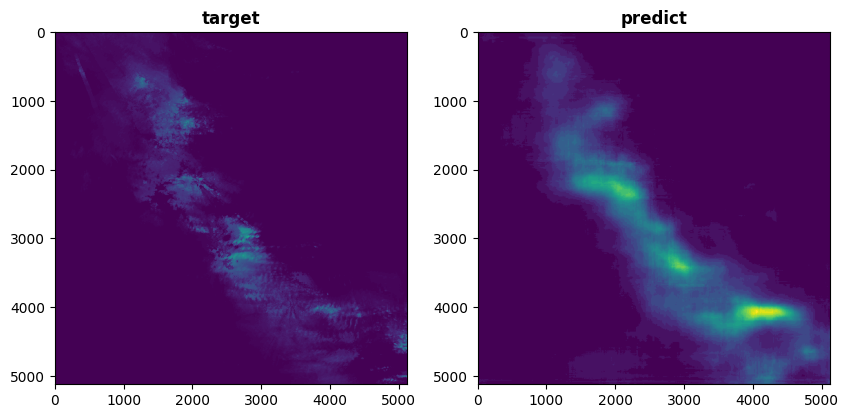

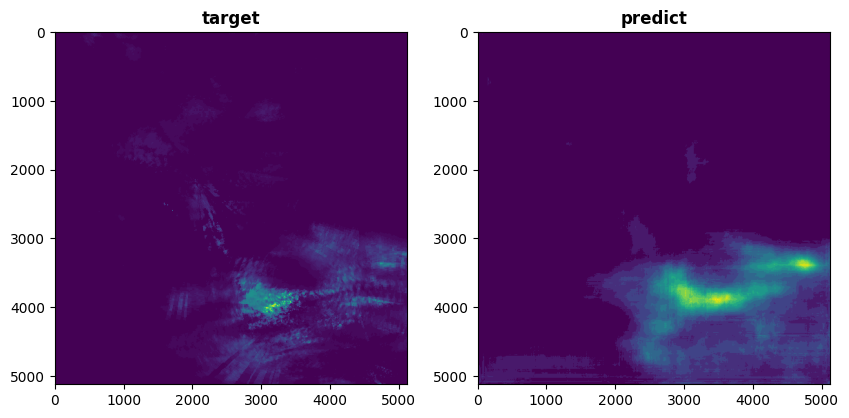

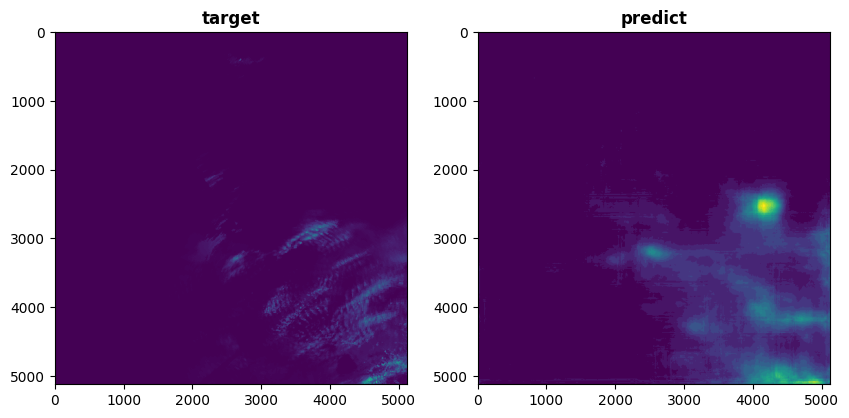

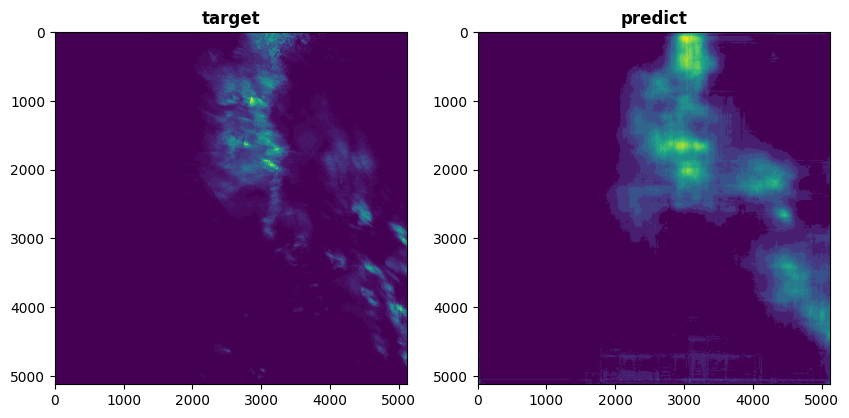

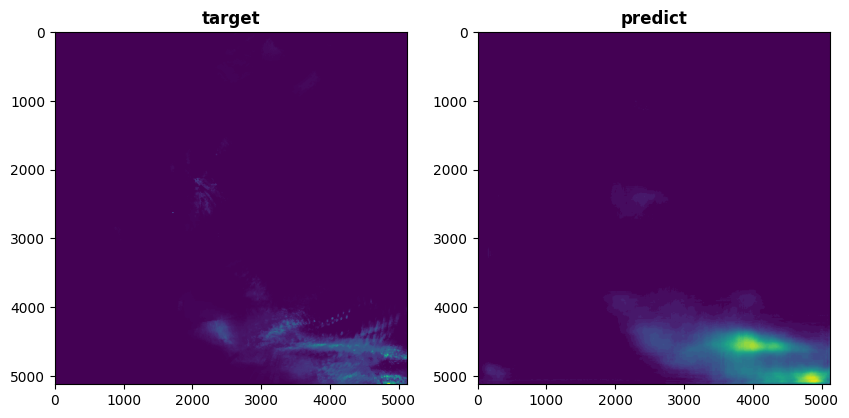

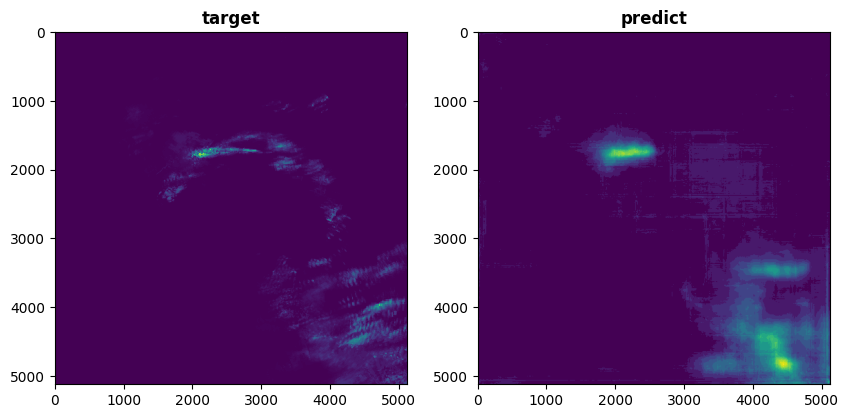

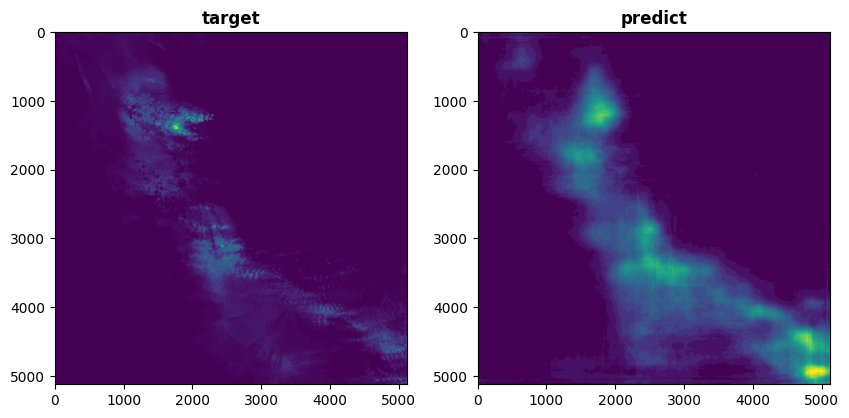

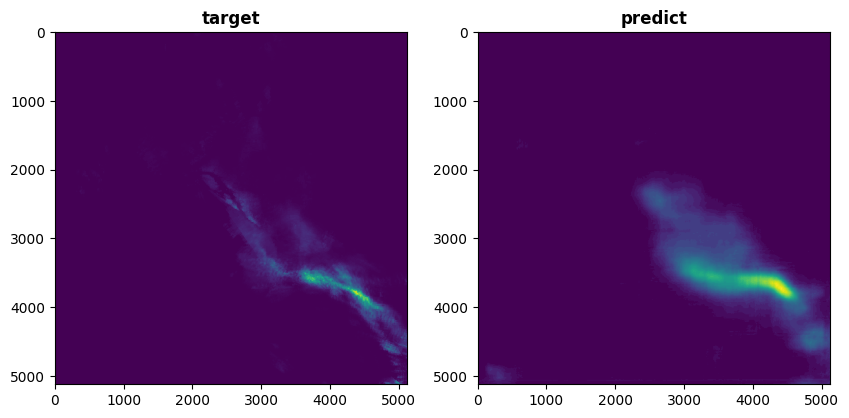

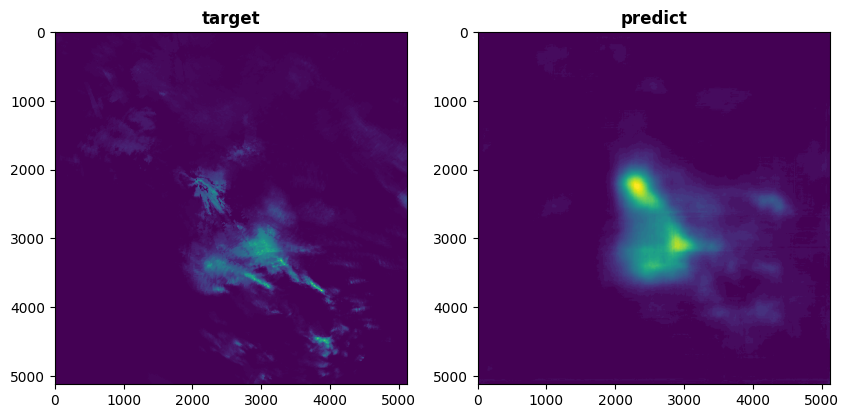

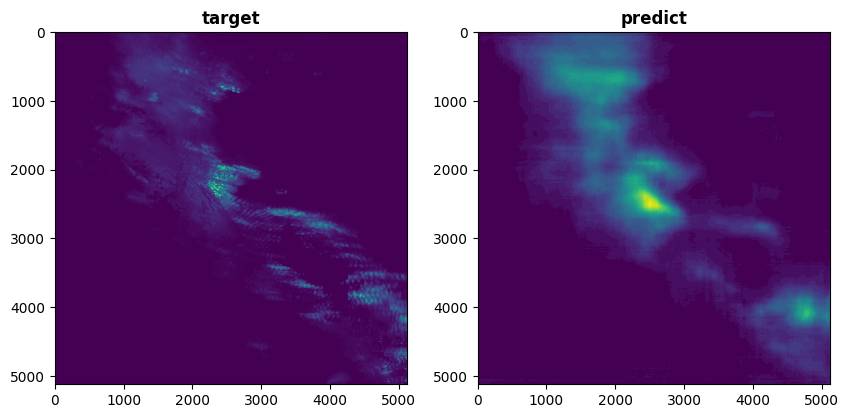

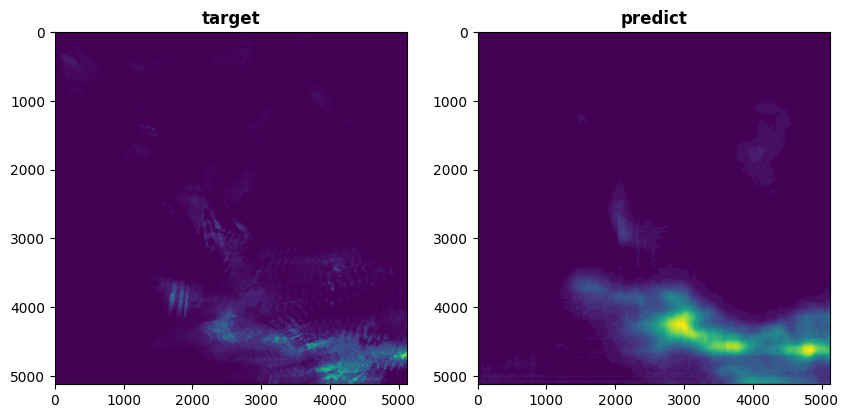

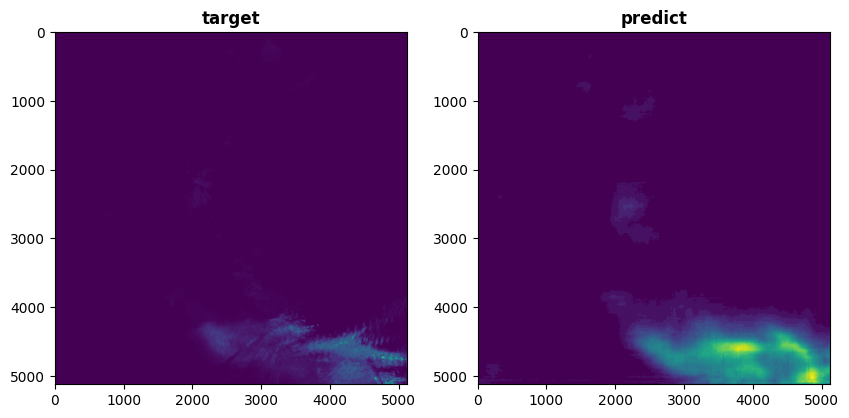

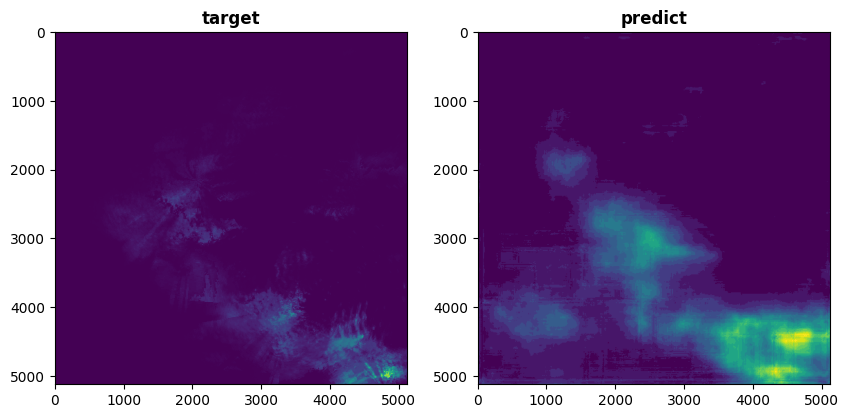

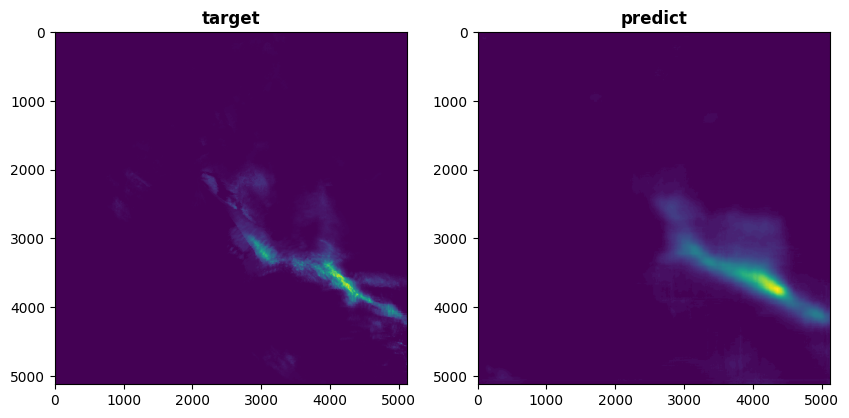

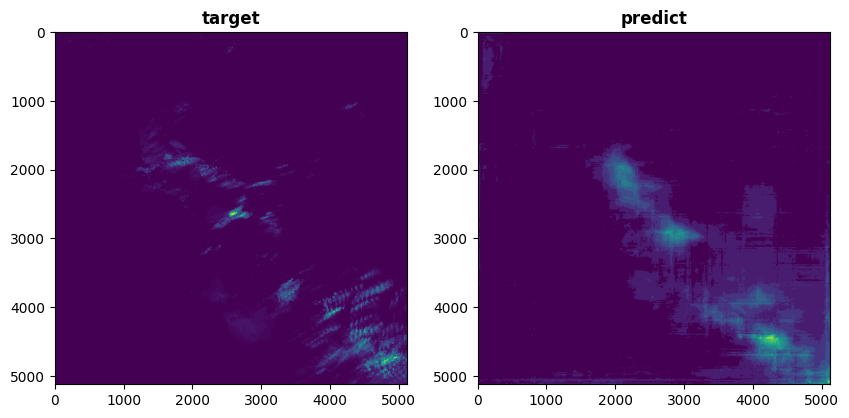

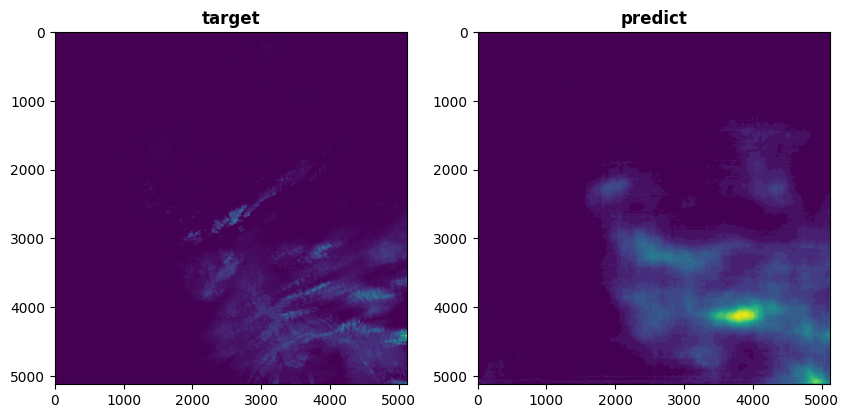

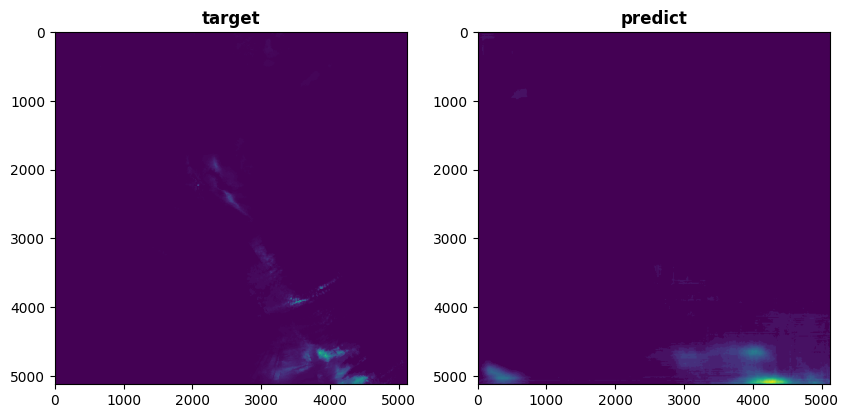

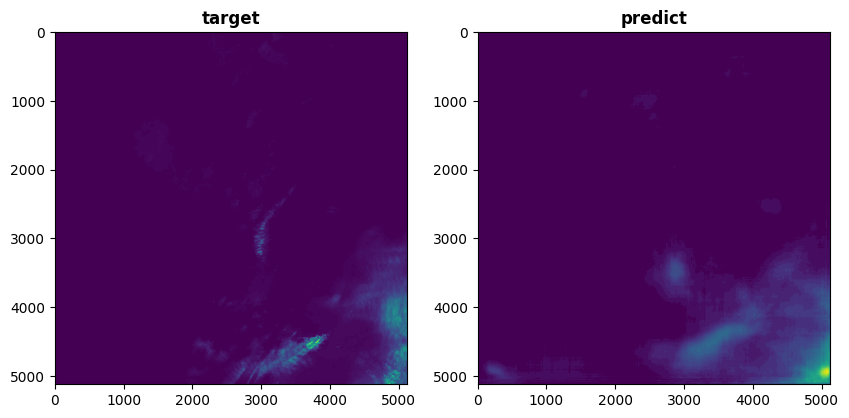

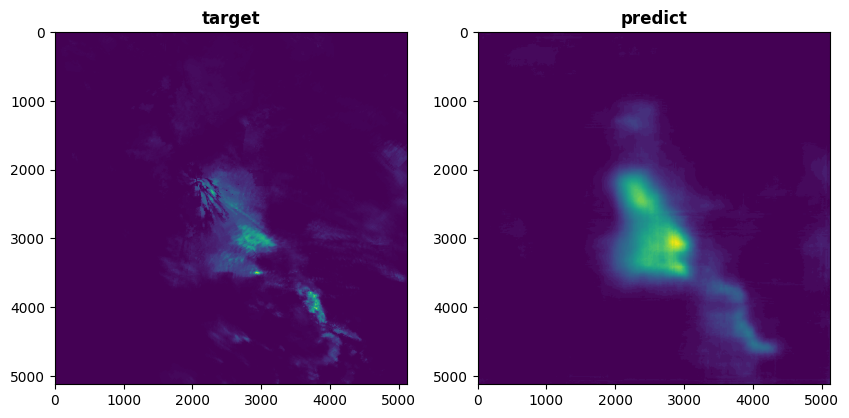

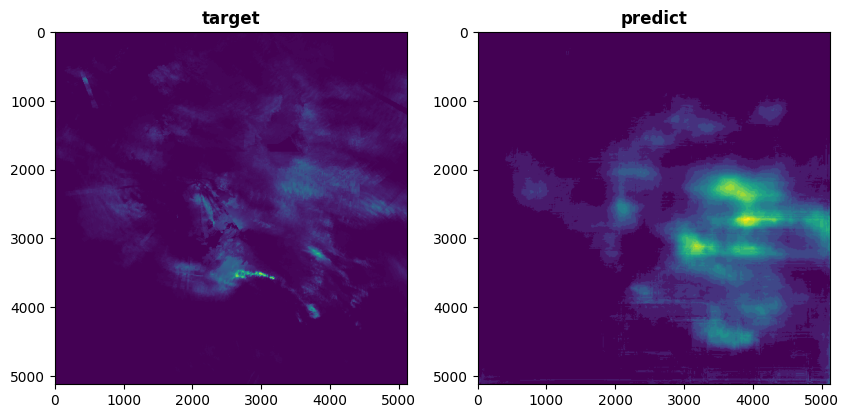

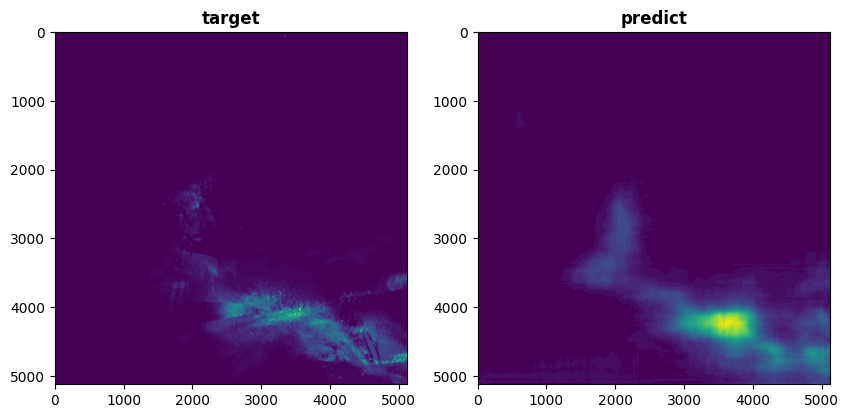

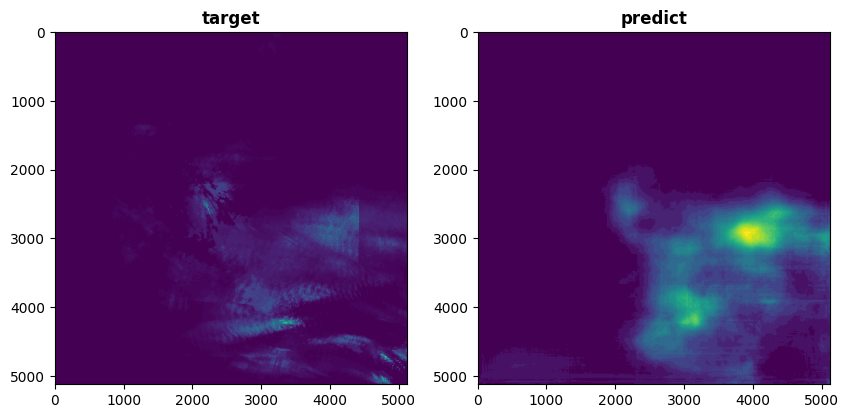

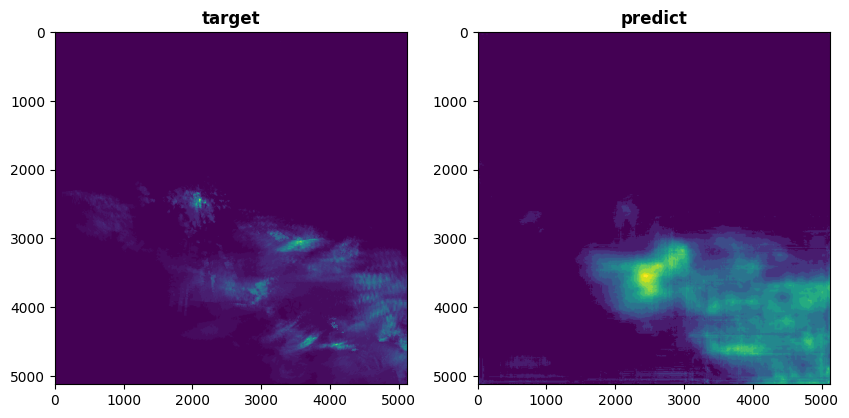

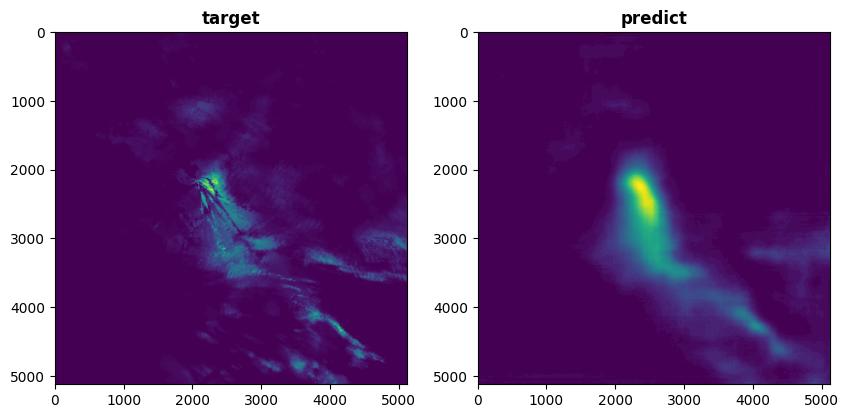

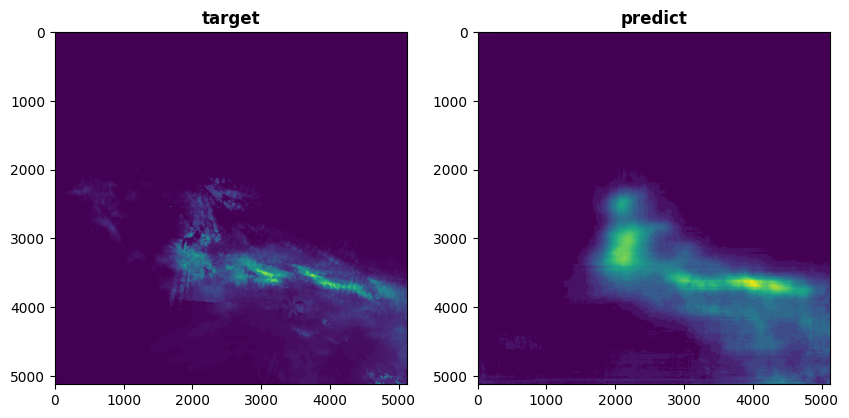

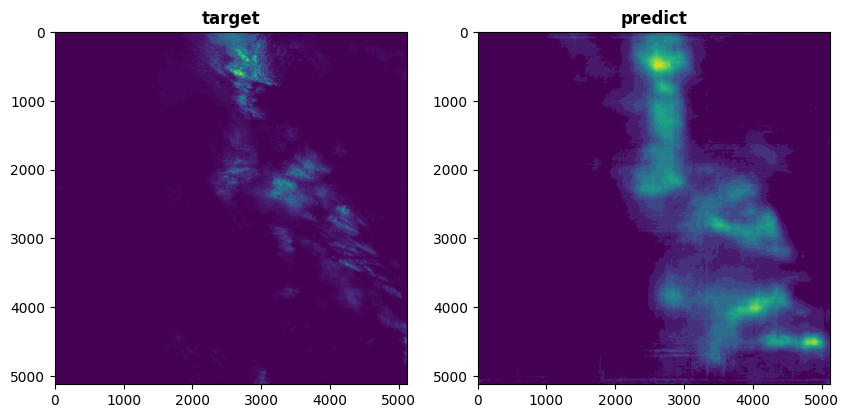

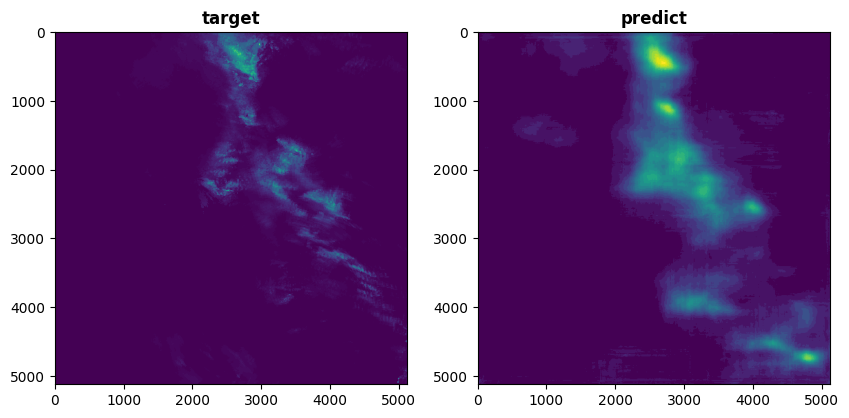

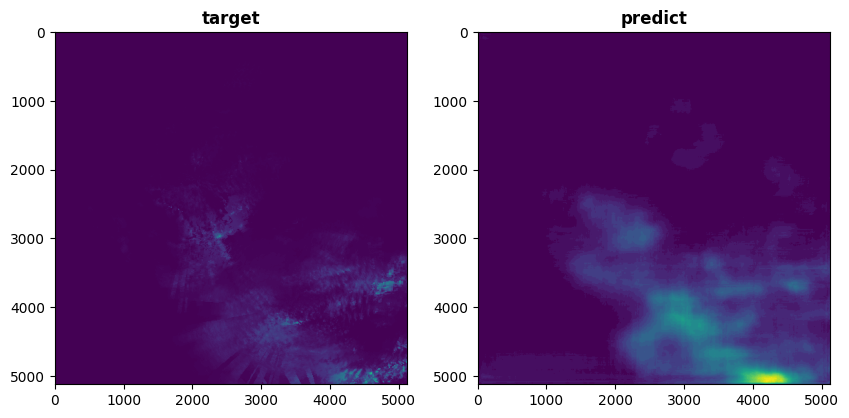

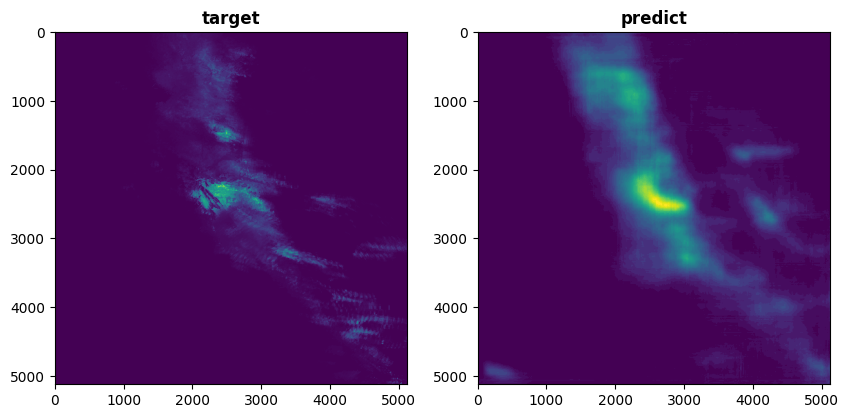

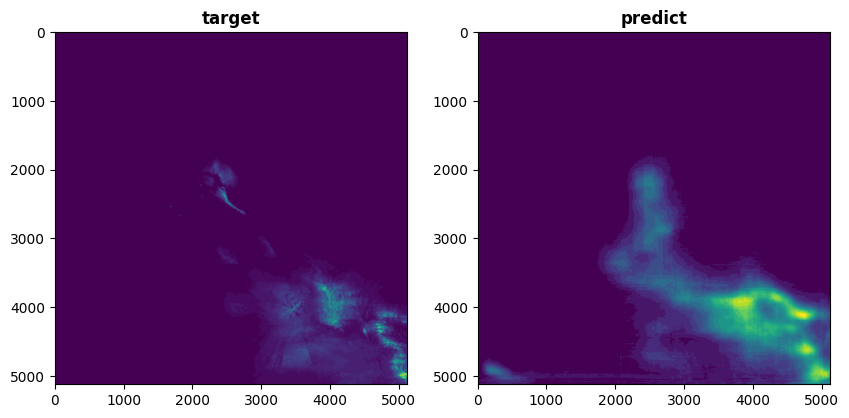

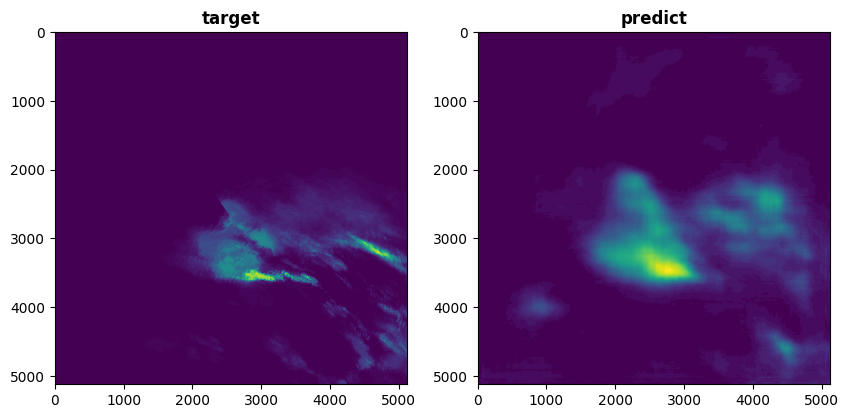

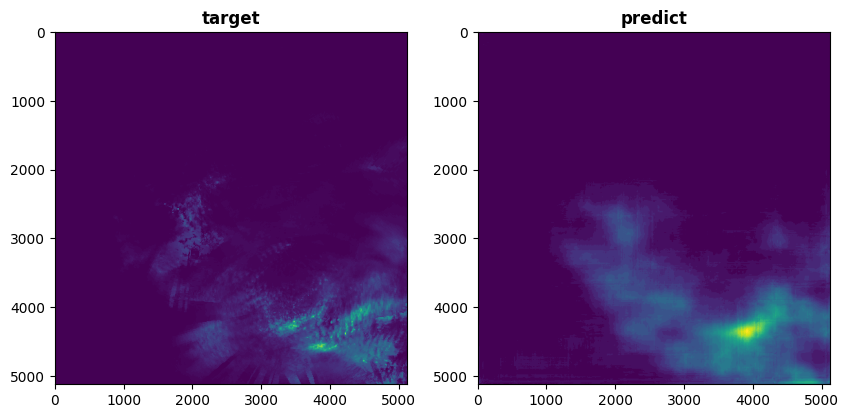

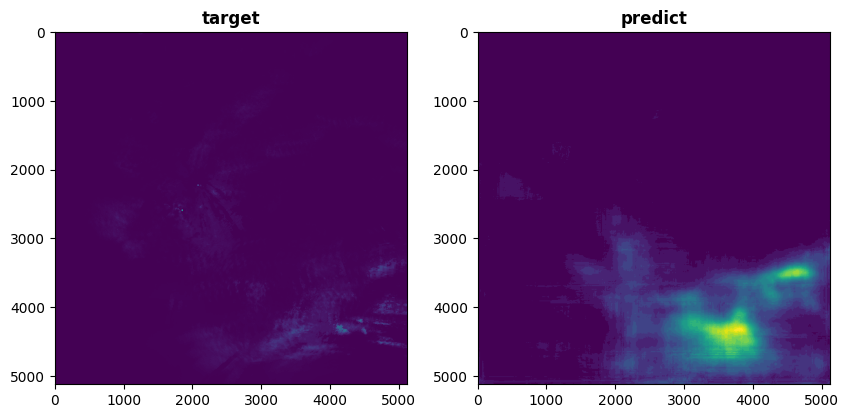

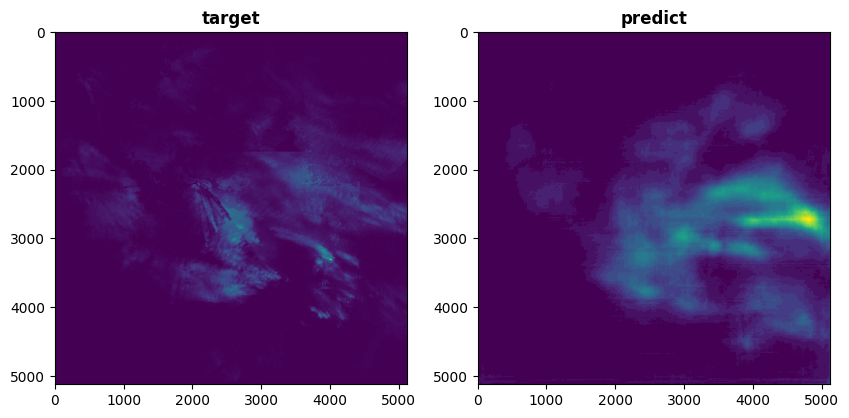

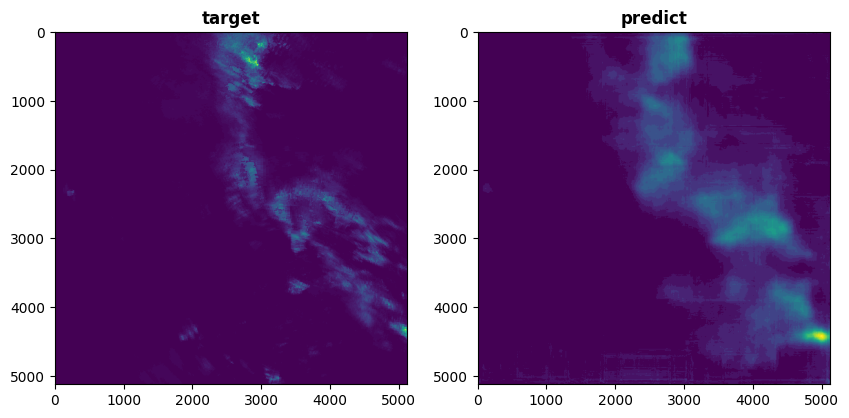

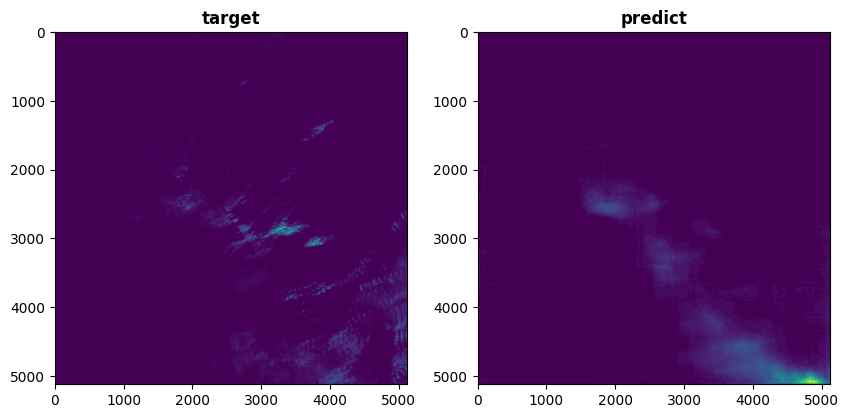

In [ ]:
rasterOrigin = (-123.25745, 45.43013)
rasterOrigin_2 = (0, 0)
pixelWidth = 10
pixelHeight = 10
count = 0

for i in range(13):
  for j in range(CFG.batch_size):
    count = count + 1
    array2raster('pred_%x.tif'%(i * 10 + j), rasterOrigin_2, pixelWidth, pixelHeight, pred[i][j].cpu().squeeze(0).numpy())
    array2raster('target_%x.tif'%(i * 10 + j), rasterOrigin_2, pixelWidth, pixelHeight, target[i][j].cpu().squeeze(0).numpy())
    plot('target_%x.tif'%(i * 10 + j), 'pred_%x.tif'%(i * 10 + j))

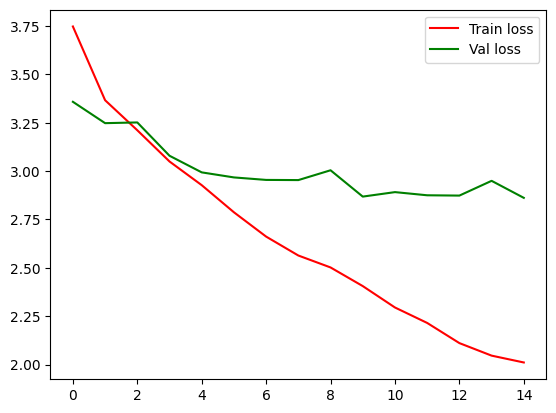

In [ ]:
plt.figure(1)
plt.plot(train_losses, 'r', label='Train loss')
plt.plot(val_losses, 'g', label='Val loss')
plt.legend()
plt.show()